# ESG Risk Score Prediction
EDA and Model Training Notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib, os
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import shap

sns.set(style="whitegrid", palette="muted", font_scale=1.1)


c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = "D:\projects\ESG-Risk-Scoring-System\data\merged_data.csv"
df = pd.read_csv(data_path)

df['date'] = pd.to_datetime(df['date'], errors='coerce')

df.shape, df.head()

((220, 26),
   company sector  carbon_emissions  diversity_ratio  governance_score  \
 0    AAPL   Tech         2300000.0             0.31              88.5   
 1    AAPL   Tech         2300000.0             0.31              88.5   
 2    AAPL   Tech         2300000.0             0.31              88.5   
 3    AAPL   Tech         2300000.0             0.31              88.5   
 4    AAPL   Tech         2300000.0             0.31              88.5   
 
    risk_score       date  close_price  volatility  debt_to_equity  ...  \
 0   55.919509 2020-03-31       154.63       0.018            0.92  ...   
 1   71.970569 2020-06-30       154.63       0.012            0.93  ...   
 2   78.194591 2020-09-30       154.63       0.018            0.92  ...   
 3   31.004271 2020-12-31       154.63       0.018            0.92  ...   
 4   37.473748 2021-03-31       156.32       0.018            1.23  ...   
 
          name  sentiment keywords  carbon_cost_est  sentiment_missing  \
 0  Apple Inc.  

In [3]:
# Basic info
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Nulls:\n", df.isna().sum())

# Summary statistics
display(df.describe(include="all"))

Shape: (220, 26)
Columns: ['company', 'sector', 'carbon_emissions', 'diversity_ratio', 'governance_score', 'risk_score', 'date', 'close_price', 'volatility', 'debt_to_equity', 'portfolio_weight', 'investment_value', 'region', 'carbon_tax_rate', 'climate_risk_index', 'interest_rate', 'name', 'sentiment', 'keywords', 'carbon_cost_est', 'sentiment_missing', 'log_carbon_emissions', 'log_close_price', 'log_investment_value', 'vol_x_dte', 'keywords_len']
Nulls:
 company                   0
sector                    0
carbon_emissions          0
diversity_ratio           0
governance_score          0
risk_score                0
date                      0
close_price               0
volatility                0
debt_to_equity            0
portfolio_weight          0
investment_value          0
region                    0
carbon_tax_rate           0
climate_risk_index        0
interest_rate             0
name                      0
sentiment                 0
keywords                220
carbon_

,company,sector,carbon_emissions,diversity_ratio,governance_score,risk_score,date,close_price,volatility,debt_to_equity,...,name,sentiment,keywords,carbon_cost_est,sentiment_missing,log_carbon_emissions,log_close_price,log_investment_value,vol_x_dte,keywords_len
count,220,220,2.200000e+02,220.000000,220.000000,220.000000,220,220.000000,220.000000,220.000000,...,220,220.0,0.0,220.000000,220.0,220.000000,220.000000,220.000000,220.000000,220.0
unique,10,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,AAPL,Tech,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Apple Inc.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,22,66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2.542727e+06,0.426273,83.711818,51.818865,2022-11-14 17:27:16.363636480,396.193727,0.047505,1.022045,...,NaN,0.0,NaN,152563.636364,0.0,14.741571,5.211152,13.541536,0.047398,1.0
min,NaN,NaN,2.300000e+06,0.280000,72.000000,20.650259,2020-03-31 00:00:00,33.720000,0.012000,0.450000,...,NaN,0.0,NaN,138000.000000,0.0,14.648420,3.547316,11.500559,0.011160,1.0
25%,NaN,NaN,2.300000e+06,0.310000,78.000000,37.333133,2021-06-30 00:00:00,120.500000,0.018000,0.750000,...,NaN,0.0,NaN,138000.000000,0.0,14.648420,4.799914,13.245641,0.022140,1.0
50%,NaN,NaN,2.500000e+06,0.315000,88.300000,52.186437,2022-11-15 00:00:00,128.600000,0.060000,1.230000,...,NaN,0.0,NaN,150000.000000,0.0,14.731802,4.862963,13.650261,0.045000,1.0
75%,NaN,NaN,2.500000e+06,0.620000,88.500000,67.397252,2024-03-31 00:00:00,245.670000,0.060000,1.250000,...,NaN,0.0,NaN,150000.000000,0.0,14.731802,5.508051,14.077447,0.073800,1.0
max,NaN,NaN,3.500000e+06,0.620000,88.500000,79.983060,2025-06-30 00:00:00,2200.560000,0.070000,1.350000,...,NaN,0.0,NaN,210000.000000,0.0,15.068274,7.696921,14.718664,0.087500,1.0


In [4]:
# Time range
print("Date range:", df['date'].min(), "to", df['date'].max())

# Companies & sectors
print("Unique companies:", df['company'].nunique())
print("Unique sectors:", df['sector'].nunique())

Date range: 2020-03-31 00:00:00 to 2025-06-30 00:00:00
Unique companies: 10
Unique sectors: 6


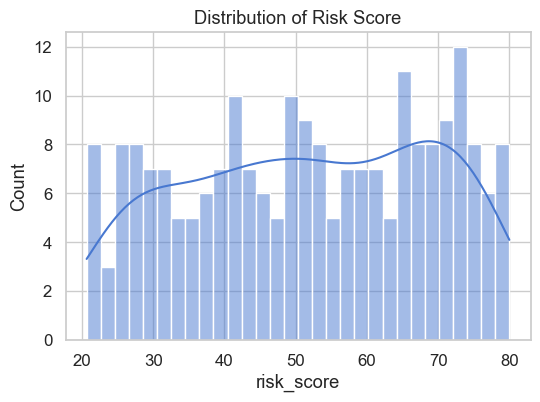

In [5]:
# Distribution of target
plt.figure(figsize=(6,4))
sns.histplot(df['risk_score'], bins=30, kde=True)
plt.title("Distribution of Risk Score")
plt.show()

In [6]:
# Time-based grouped split
def time_grouped_split(df, test_size=0.2, val_size=0.1, company_col='company', date_col='date'):
    df = df.sort_values([company_col, date_col]).reset_index(drop=True)
    test_idx, val_idx, train_idx = [], [], []
    for comp, g in df.groupby(company_col):
        n = len(g)
        n_test = int(np.floor(n * test_size))
        n_val = int(np.floor(n * val_size))
        idxs = g.index.to_list()
        test_idx.extend(idxs[-n_test:] if n_test > 0 else [])
        val_idx.extend(idxs[-(n_test + n_val):-n_test] if n_val > 0 else [])
        train_idx.extend(idxs[: max(0, n - n_test - n_val)])
    return np.array(train_idx), np.array(val_idx), np.array(test_idx)

numeric_features = [
    "carbon_emissions",
    "diversity_ratio",
    "governance_score",
    "close_price",
    "volatility",
    "debt_to_equity",
    "portfolio_weight",
    "investment_value",
    "carbon_tax_rate",
    "climate_risk_index",
    "interest_rate",
    "carbon_cost_est",
    "log_carbon_emissions",
    "log_close_price",
    "log_investment_value",
    "vol_x_dte",
    "keywords_len"
]

categorical_features = [
    "region",
    "sentiment",        
    "sentiment_missing"
]

target_col = 'risk_score'

train_idx, val_idx, test_idx = time_grouped_split(df)
X = df[numeric_features + categorical_features]
y = df[target_col].values

X_train, X_val, X_test = X.iloc[train_idx], X.iloc[val_idx], X.iloc[test_idx]
y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]

print("Train/Val/Test sizes:", len(train_idx), len(val_idx), len(test_idx))

Train/Val/Test sizes: 160 20 40


## Model Training and Comparison

In [7]:

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline([("imputer", SimpleImputer(strategy="median"))])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

models = [
    ("Ridge", Ridge(alpha=1.0, random_state=42)),
    ("RandomForest", RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)),
    ("HGB", HistGradientBoostingRegressor(learning_rate=0.05, random_state=42))
]

results = []
for name, model in models:
    pipe = Pipeline([("prep", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    preds_val = pipe.predict(X_val)
    preds_test = pipe.predict(X_test)
    results.append({
        "model": name,
        "val_rmse": np.sqrt(mean_squared_error(y_val, preds_val)),
        "val_r2": r2_score(y_val, preds_val),
        "test_rmse": np.sqrt(mean_squared_error(y_test, preds_test)),
        "test_r2": r2_score(y_test, preds_test)
    })

# XGBoost with early stopping
preprocessor.fit(X_train)
X_train_prep = preprocessor.transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)

xgb = XGBRegressor(
    n_estimators=5000, learning_rate=0.02, max_depth=5,
    subsample=0.8, colsample_bytree=0.8,
    reg_lambda=2.0, min_child_weight=2,
    random_state=42, n_jobs=-1, tree_method="hist"
)
xgb.fit(X_train_prep, y_train, eval_set=[(X_val_prep, y_val)], verbose=False)

val_pred = xgb.predict(X_val_prep)
test_pred = xgb.predict(X_test_prep)
results.append({
    "model": "XGBoost",
    "val_rmse": np.sqrt(mean_squared_error(y_val, val_pred)),
    "val_r2": r2_score(y_val, val_pred),
    "test_rmse": np.sqrt(mean_squared_error(y_test, test_pred)),
    "test_r2": r2_score(y_test, test_pred)
})

results_df = pd.DataFrame(results).sort_values("val_rmse")
results_df


,model,val_rmse,val_r2,test_rmse,test_r2
0,Ridge,18.588517,-0.128817,19.715925,-0.414647
2,HGB,19.054171,-0.186080,20.351675,-0.507349
1,RandomForest,20.342250,-0.351861,21.585704,-0.695689
3,XGBoost,21.655319,-0.532016,22.590026,-0.857151


In [8]:
best_row = results_df.iloc[0]
best_model_name = best_row["model"]
print("Best model:", best_model_name)

Best model: Ridge


In [9]:
trval_idx = np.concatenate([train_idx, val_idx])
X_trval, y_trval = X.iloc[trval_idx], y[trval_idx]

if best_model_name == "XGBoost":
    preprocessor.fit(X_trval)
    X_trval_prep = preprocessor.transform(X_trval)
    X_test_prep = preprocessor.transform(X_test)

    xgb_final = XGBRegressor(**xgb.get_params())
    xgb_final.fit(
        X_trval_prep, y_trval,
        eval_set=[(X_test_prep, y_test)],
        early_stopping_rounds=200,
        verbose=False
    )
    final_model = Pipeline([("prep", preprocessor), ("model", xgb_final)])
else:
    model_lookup = {
        "Ridge": Ridge(alpha=1.0, random_state=42),
        "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
        "HGB": HistGradientBoostingRegressor(learning_rate=0.05, random_state=42),
    }
    final_model = Pipeline([("prep", preprocessor), ("model", model_lookup[best_model_name])])
    final_model.fit(X_trval, y_trval)
joblib.dump(final_model, "D:\projects\ESG-Risk-Scoring-System\models\esg_risk_model.pkl")

['D:\\projects\\ESG-Risk-Scoring-System\\models\\esg_risk_model.pkl']

## SHAP Explainability

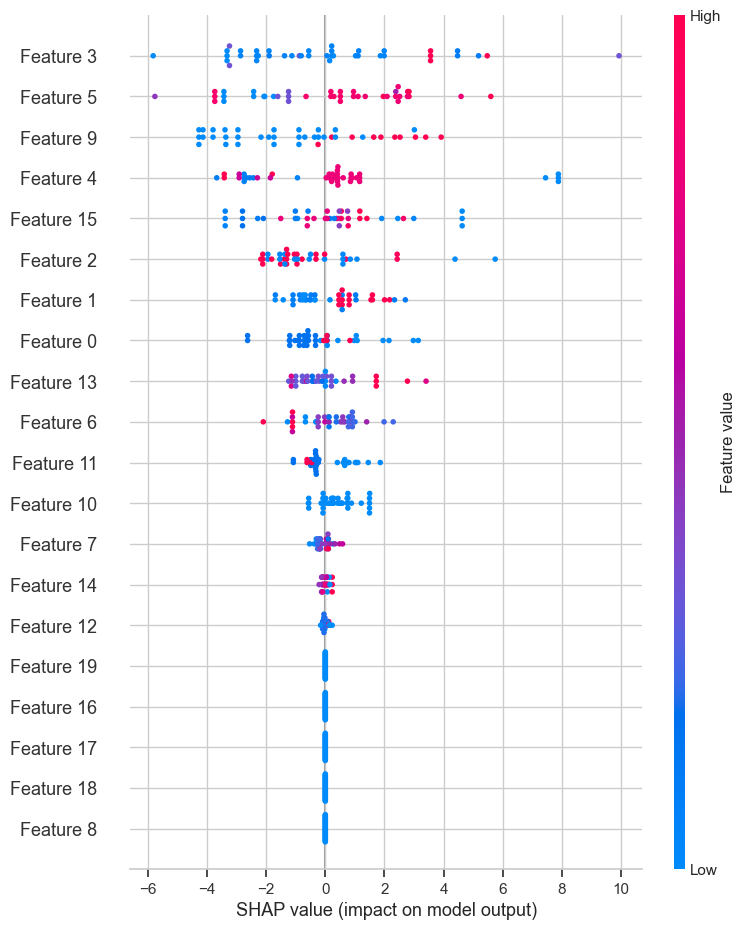

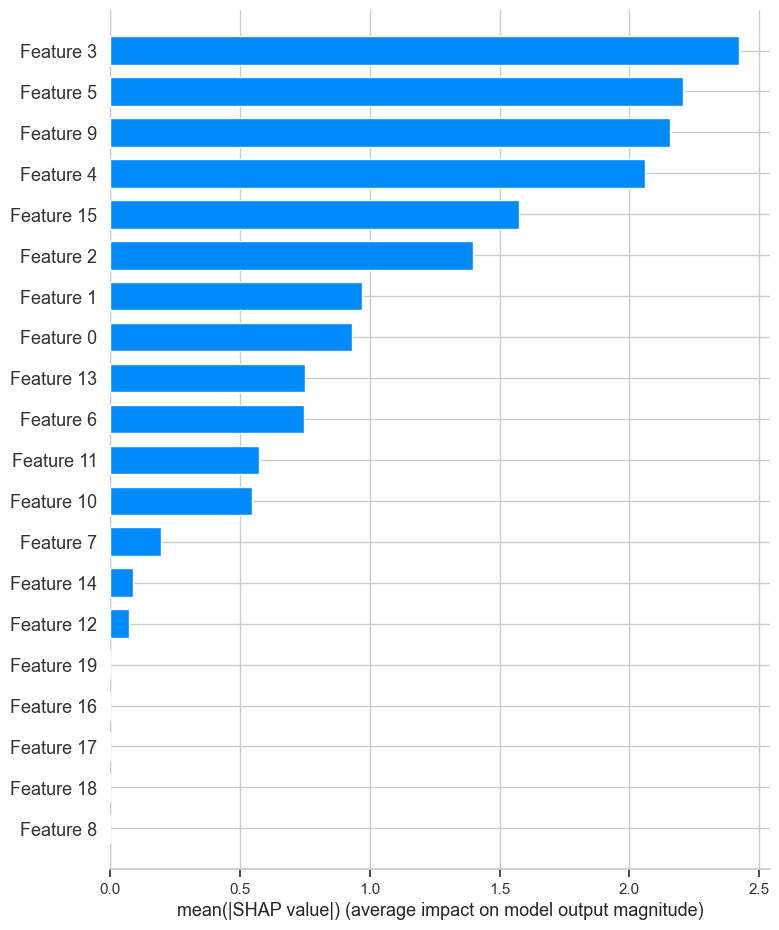

In [10]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test_prep)

plt.figure(figsize=(6,4))
shap.summary_plot(shap_values, X_test_prep, show=False)
plt.show()

plt.figure(figsize=(6,4))
shap.summary_plot(shap_values, X_test_prep, plot_type="bar", show=False)
plt.show()
